[05/27 12:23:48 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/home/capstone/.local/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[05/27 12:24:16 d2.utils.events]:  eta: 0:03:53  iter: 19  total_loss: 0.866  loss_cls: 0.211  loss_box_reg: 0.3294  loss_mask: 0.2012  loss_rpn_cls: 0.01817  loss_rpn_loc: 0.04561    time: 0.2369  last_time: 0.2399  data_time: 0.0084  last_data_time: 0.0027   lr: 2.881e-06  max_mem: 2460M


2024-05-27 12:24:17.017659: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 12:24:17.777920: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[05/27 12:24:23 d2.utils.events]:  eta: 0:03:35  iter: 39  total_loss: 0.7182  loss_cls: 0.1604  loss_box_reg: 0.2861  loss_mask: 0.1962  loss_rpn_cls: 0.01266  loss_rpn_loc: 0.03062    time: 0.2279  last_time: 0.2496  data_time: 0.0029  last_data_time: 0.0046   lr: 4.861e-06  max_mem: 2580M
[05/27 12:24:27 d2.utils.events]:  eta: 0:03:34  iter: 59  total_loss: 1.023  loss_cls: 0.2585  loss_box_reg: 0.3547  loss_mask: 0.24  loss_rpn_cls: 0.02344  loss_rpn_loc: 0.06158    time: 0.2286  last_time: 0.1948  data_time: 0.0026  last_data_time: 0.0025   lr: 6.841e-06  max_mem: 2670M
[05/27 12:24:32 d2.utils.events]:  eta: 0:03:26  iter: 79  total_loss: 0.7684  loss_cls: 0.1833  loss_box_reg: 0.3103  loss_mask: 0.2014  loss_rpn_cls: 0.01241  loss_rpn_loc: 0.02928    time: 0.2277  last_time: 0.2361  data_time: 0.0026  last_data_time: 0.0026   lr: 8.821e-06  max_mem: 2670M
[05/27 12:24:36 d2.utils.events]:  eta: 0:03:22  iter: 99  total_loss: 0.9062  loss_cls: 0.2281  loss_box_reg: 0.345  loss_m

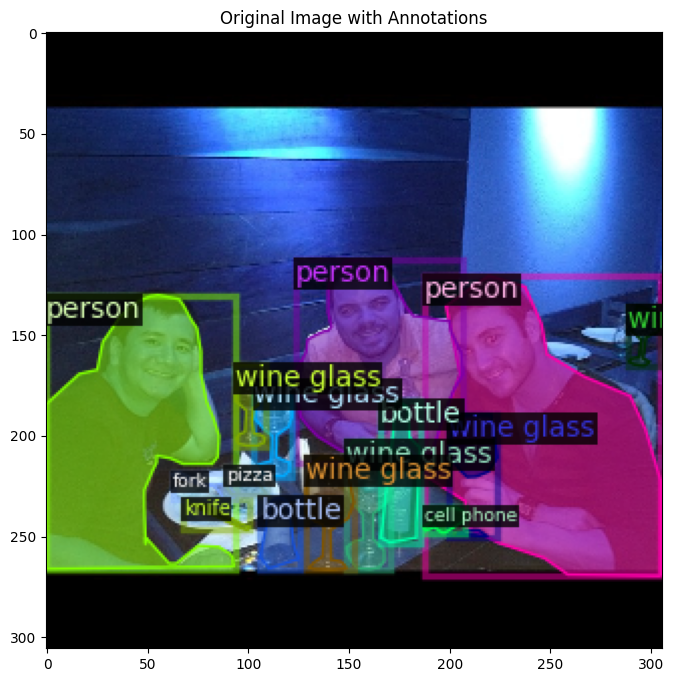

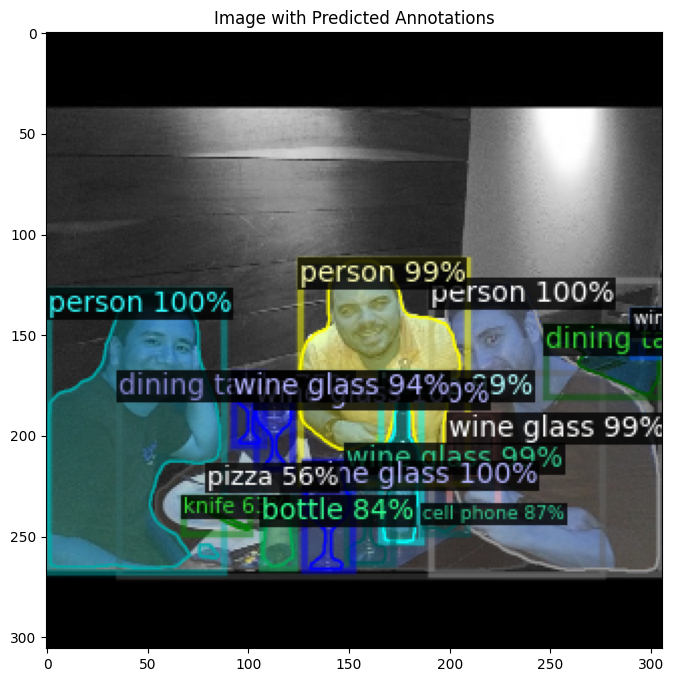

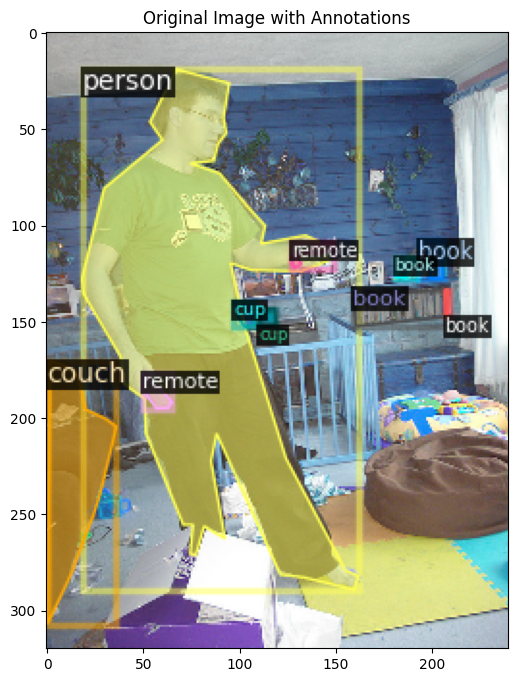

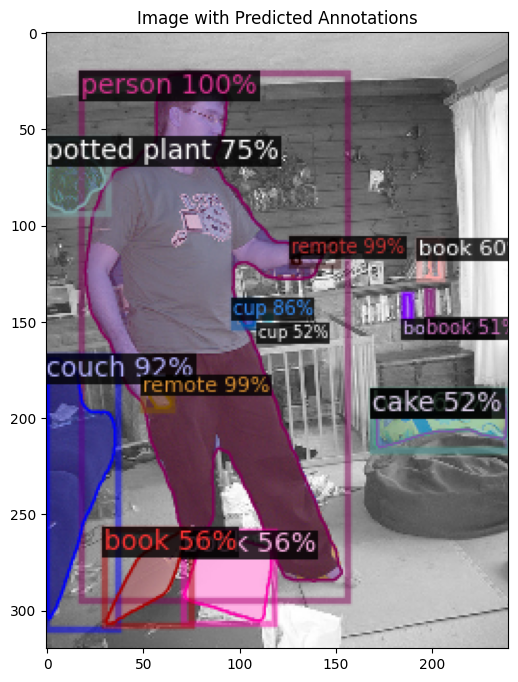

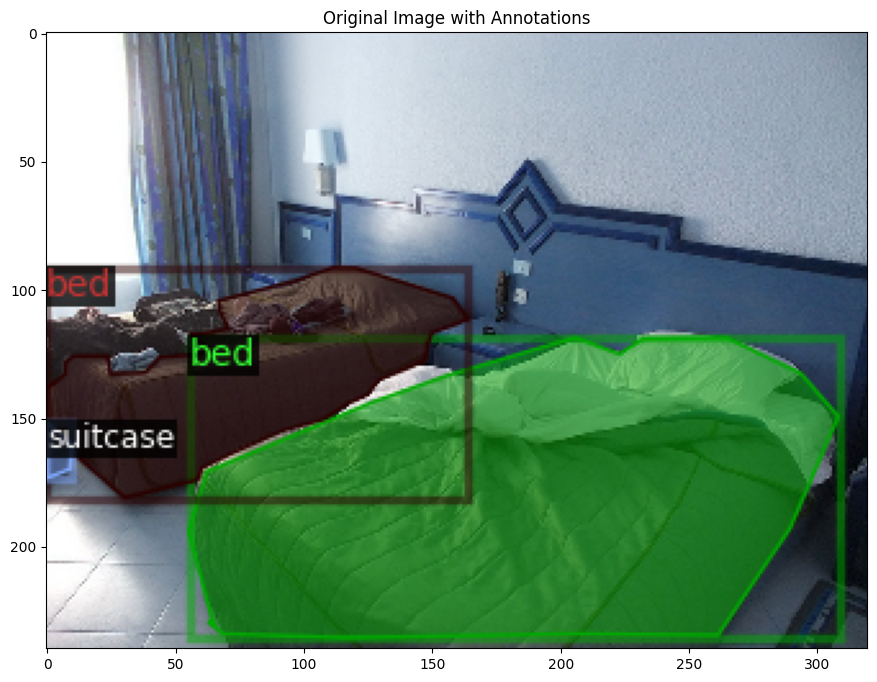

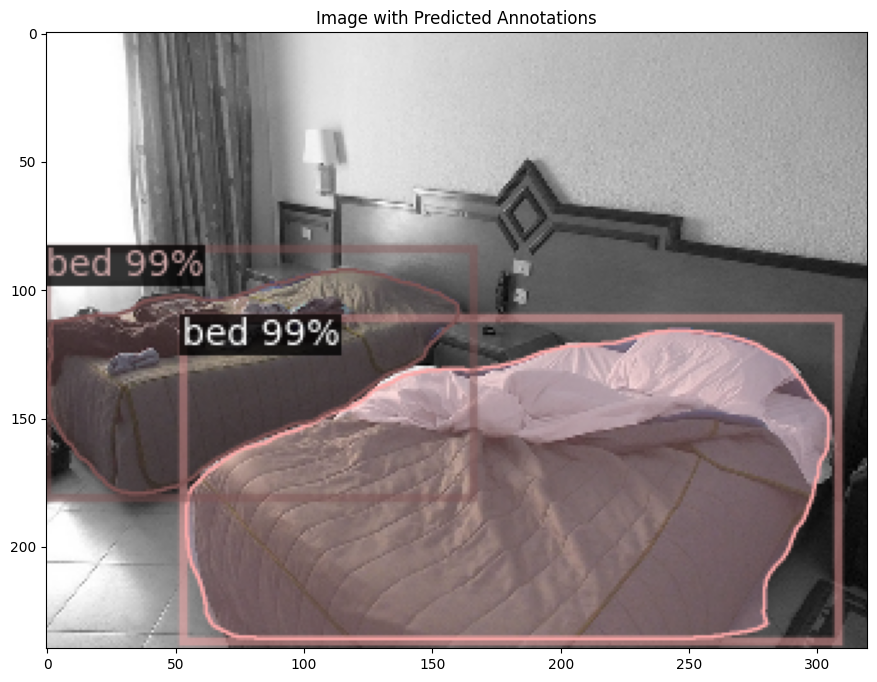

In [1]:
from detectron2.data.datasets import register_coco_instances
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
import cv2
import random
import matplotlib.pyplot as plt

# Register datasets
register_coco_instances("coco_train", {}, "annotations/instances_train2017.json", "train2017")
register_coco_instances("coco_val", {}, "annotations/instances_val2017.json", "val2017")

# Set configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("coco_train",)
cfg.DATASETS.TEST = ("coco_val",)
cfg.DATALOADER.NUM_WORKERS = 2  # Reduce the number of worker threads
cfg.SOLVER.IMS_PER_BATCH = 2  # Reduce the number of images per batch
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MAX_ITER = 1000  # Reduce the maximum number of iterations
cfg.SOLVER.STEPS = [500]  # Adjust the steps for learning rate decay
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64  # Reduce RoI batch size per image
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 80
cfg.OUTPUT_DIR = "./output"

# Custom Trainer class to add evaluator
class CocoTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = cfg.OUTPUT_DIR
        return COCOEvaluator(dataset_name, cfg, False, output_folder)

# Train the model
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

# If validation or testing is needed
evaluator = CocoTrainer.build_evaluator(cfg, "coco_val")
val_loader = build_detection_test_loader(cfg, "coco_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

# Visualize prediction results
def visualize_predictions(dataset_name, cfg):
    dataset_dicts = DatasetCatalog.get(dataset_name)
    metadata = MetadataCatalog.get(dataset_name)
    for d in random.sample(dataset_dicts, 3):  # Randomly select three images for display
        img = cv2.imread(d["file_name"])
        visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
        vis = visualizer.draw_dataset_dict(d)
        
        # Original image
        plt.figure(figsize=(12, 8))
        plt.imshow(vis.get_image()[:, :, ::-1])
        plt.title("Original Image with Annotations")
        plt.show()

        # Image after inference
        outputs = predictor(img)
        v = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5, instance_mode=ColorMode.IMAGE_BW)
        v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        
        plt.figure(figsize=(12, 8))
        plt.imshow(v.get_image()[:, :, ::-1])
        plt.title("Image with Predicted Annotations")
        plt.show()

# Create predictor
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set the testing threshold
predictor = DefaultPredictor(cfg)

# Visualize prediction results
visualize_predictions("coco_val", cfg)
